In [1]:
import sys
sys.path.append("..")
from IPython.display import display

In [175]:
import numpy as np
import logging
import pickle
import time
import importlib 

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)

import matplotlib as mpl
from matplotlib import rcParams
from matplotlib.colors import Normalize
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from matplotlib import ticker
from matplotlib import colors
from matplotlib.patches import Ellipse
from matplotlib import gridspec



In [222]:
from scripts import reclusterTree
from scripts import linkageList
from scripts import heatClustermap
from scripts import Tree1D
from scripts import likelihood
from scripts import beamsearchTJS
from scripts import N2Greedy
from scripts import beamSearch as bs
# from scripts import multib_beamSearch
from scripts import beamSearchOptimal as BSO

In [223]:
"""Reload filles after changes"""
importlib.reload(reclusterTree)
importlib.reload(linkageList)
importlib.reload(heatClustermap)
importlib.reload(Tree1D)
importlib.reload(likelihood)
importlib.reload(N2Greedy)
importlib.reload(bs)
importlib.reload(BSO)

<module 'scripts.beamSearchOptimal' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearchOptimal.py'>

In [9]:
"""Data dir"""
input_dir= 'data/'
# input_dir ="../ToyJetsShower/data/"

# RECLUSTERING ALGORITHMS TESTED ON JETS GENERATED WITH THE TOY GENERATIVE MODEL 

In [1159]:
# input_jet = 'tree_13_truth'
# input_jet = 'tree_10_truth'
# input_jets = 'tree_4_truth'
# input_jets = 'tree_100_truth'
input_jets = 'tree_1000_truth'

# ALGORITHMS COMPARISON

Functions to run the reclustering algorithms over a list of jets

### Greedy Algorithm

In [17]:
def fill_GreedyList(truth_jets):

    
    startTime= time.time()

    greedyJets = [ N2Greedy.recluster(
        truth_jet,
        delta_min =  truth_jet["pt_cut"] ,
        lam = float(truth_jet["Lambda"]),
        visualize = False,
    ) for truth_jet in truth_jets]

    print("TOTAL TIME = ",time.time() -startTime)
    
    greedyJetsLogLH = [sum(jet["logLH"]) for jet in greedyJets]
    
    return greedyJets, greedyJetsLogLH

### Beam Search Algorithm

In [18]:
def fill_BSList(input_jets, Nbest = 1):
    
    input_dir= 'data/'
    
    with open(input_dir+ str(input_jets) + '.pkl', "rb") as fd: 
        truth_jets = pickle.load(fd, encoding='latin-1')
    
    startTime= time.time()
    BSO_jetsList =[]

    for i,truth_jet in enumerate(truth_jets):
        
            if i%10==0:
                print(" # of reclustered jets = ",i)
                print("PARTIAL TIME = ",time.time() -a)
                a = time.time()

            N = len(truth_jet["leaves"])

            BSO_jetsList.append(BSO.recluster( 
                truth_jet, 
                beamSize = min(3*N,np.asarray(N*(N-1)/2 ).astype(int)),
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[0]
            )

    print("TOTAL TIME = ",time.time() -startTime)
    
    BSO_jetsListLogLH = [sum(jet["logLH"]) for jet in BSO_jetsList]
    
    return BSO_jetsList, BSO_jetsListLogLH

## COMPARISON

In [252]:
jets = "tree_100_truth"

with open(input_dir+ str(jets) + '.pkl', "rb") as fd: 
    truth_jets = pickle.load(fd, encoding='latin-1')

In [261]:
truth_jets[0]["content"][truth_jets[0]["root_id"]]

array([500., 400.], dtype=float32)

In [263]:
truth_jets[0]["Lambda"]

tensor(3.6000)

In [264]:
truth_jets[0]["pt_cut"]

0.04

In [236]:
"""Number of jet constituents"""
Nconst100 = []
for jet in truth_jets:
    Nconst100.append(len(jet["leaves"]))
    
NconstAvg100 =np.average(Nconst100)
display(NconstAvg100)

36.82

#### Truth jet log LH

In [237]:
"""Fill list with log likelihood of truth jet"""
enrichTruthLogLH = [likelihood.enrich_jet_logLH(truth_jet) for truth_jet in truth_jets]

In [238]:
truthLogLH100 =[ np.sum(truth_jet["logLH"]) for truth_jet in truth_jets]
# display(truth_logLH)

In [240]:
np.average(truthLogLH100)

-85.0235048007965

#### Greedy

In [233]:
greedy_jets100, greedy_jetsLogLH100 = fill_GreedyList(truth_jets)

TOTAL TIME =  7.929852247238159


In [234]:
np.average(greedy_jetsLogLH100)

-93.19280508155062

#### Beam Search

In [1180]:
BSO_jetsList100, BSO_jetsListLogLH100 = fill_BSList('tree_100_truth')

 # of reclustered jets =  0
 # of reclustered jets =  10
 # of reclustered jets =  20
 # of reclustered jets =  30
 # of reclustered jets =  40
 # of reclustered jets =  50
 # of reclustered jets =  60
 # of reclustered jets =  70
 # of reclustered jets =  80
 # of reclustered jets =  90
TOTAL TIME =  3824.3677971363068


In [1274]:
with open("data/reclustJets/BSjets100.pkl", "wb") as f: pickle.dump((BSO_jetsList100,BSO_jetsListLogLH100), f) 

In [245]:
with open("data/reclustJets/BSjets100.pkl", "rb") as fd:  BSO_jetsList100,BSO_jetsListLogLH100 = pickle.load(fd, encoding='latin-1')

In [246]:
np.average(BSO_jetsListLogLH100)

-78.56798094361608

#### Plots

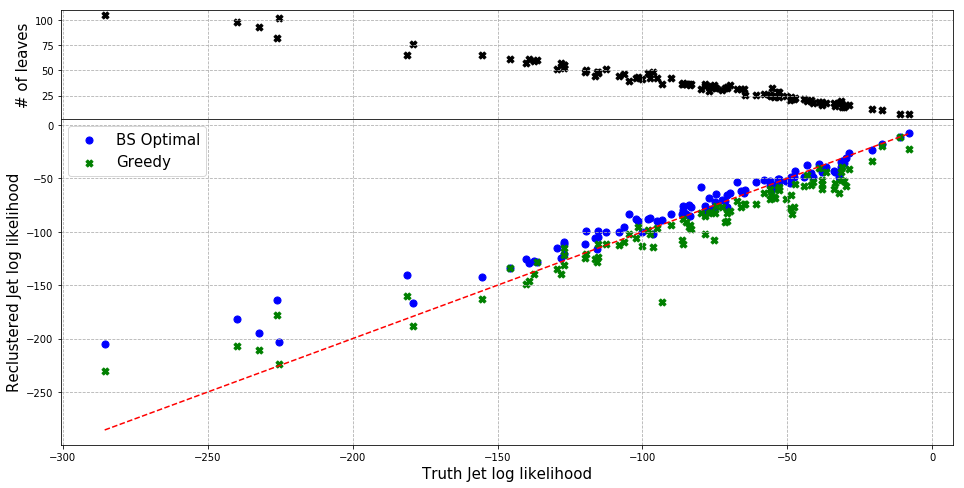

In [247]:
fig3 = plt.figure()
gs = fig3.add_gridspec(2, 1, height_ratios=[1, 3]) 
# gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3]) 
fig3.set_size_inches(16,8)

plt.title('Truth vs Reclustered Jets Log likelihood', fontsize = 25)
markersize = 50

ax2 = plt.subplot(gs[0])
ax2.scatter(truthLogLH100 , Nconst100, color="black", marker = "X", s=markersize)
ax2.grid(which='both',axis='both',linestyle='--')
ax2.set_ylabel(r"# of leaves", fontsize=15)


plt.subplots_adjust(hspace=.0)
ax1 = plt.subplot(gs[1], sharex = ax2)
ax1.scatter(truthLogLH100 , BSO_jetsListLogLH100, color='blue', marker="o", s=markersize, label = "BS Optimal")
ax1.scatter(truthLogLH100 , greedy_jetsLogLH100, color="Green", marker = "X", s=markersize, label = "Greedy")
x = np.linspace(min(truthLogLH100), max(truthLogLH100), 1000)
ax1.plot(x, x, color="red", linestyle='--')
ax1.grid(which='both',axis='both',linestyle='--')
ax1.set_xlabel(r"Truth Jet log likelihood", fontsize=15)
ax1.set_ylabel(r"Reclustered Jet log likelihood", fontsize=15)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.legend(loc='best', fontsize=15)
plt.grid(which='both',axis='both',linestyle='--')

plt.subplots_adjust(hspace=.0)
plt.show()


# Beam Size Comparisons

In [57]:
importlib.reload(bs)
importlib.reload(BSO)

<module 'scripts.beamSearchOptimal' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamSearchOptimal.py'>

In [27]:
def truthLogLH(truth_jet,k=0):
    """ Truth jet log likelihood """
    
    likelihood.enrich_jet_logLH(truth_jet)
        
    LogLH = np.sum(truth_jet["logLH"]) 
    
    return LogLH

In [155]:
def reclustGreedyJet(truth_jet):
    """ Greedy jet reclustering """

    greedyJet = N2Greedy.recluster(
        truth_jet,
        delta_min =  truth_jet["pt_cut"] ,
        lam = float(truth_jet["Lambda"]),
        visualize = False,
    )
    
    GreedyLogLH = sum(greedyJet["logLH"])
    
    return greedyJet, GreedyLogLH

In [248]:
def beamSize_BSOList(truth_jet, beamsizeList, Nbest =1):
    """ Beam size scan for the Optimal Beam Search algorithm"""

    BSOtimeList=[]
    BSO_jets =[]

    for i in beamsizeList:  

            startTime= time.time()

            BSO_jets.append(
                BSO.recluster( 
                truth_jet, 
                beamSize = i,
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[0]  
            )

            BSOtimeList.append(time.time() -startTime)
            
    BSO_jetsLogLH = [sum(jet["logLH"]) for jet in BSO_jets]
    
    return BSOtimeList, BSO_jets, BSO_jetsLogLH

In [249]:
def beamSize_BSList(truth_jet, beamsizeList, Nbest =1):
    """ Beam size scan for the Beam Search algorithm"""
        
    bstimeList=[]
    bs_jets =[]

    for i in beamsizeList:  

            startTime= time.time()

            bs_jets.append(
                bs.recluster( 
                truth_jet, 
                beamSize = i,
                delta_min =  truth_jet["pt_cut"],
                lam = float(truth_jet["Lambda"]),
                N_best = Nbest,
            )[-1]  
            )

            bstimeList.append(time.time() -startTime)
            
    bs_jetsLogLH = [sum(jet["logLH"]) for jet in bs_jets]
    
    return bstimeList, bs_jets, bs_jetsLogLH

### Beam size scan and plotting  functions

In [201]:
def BeamSizeLogLH(jetsName,  filename="", k=0):
    
    with open(input_dir+ str(jetsName) + '.pkl', "rb") as fd: 
        truth_jet = pickle.load(fd, encoding='latin-1')[int(k)]
    
    truthConst = N2Greedy.getConstituents(
    truth_jet,
	truth_jet["root_id"],
	[],
    )
    
    N = len(truthConst)
    
    likelihood.enrich_jet_logLH(truth_jet)
        
    truthLogLH = np.sum(truth_jet["logLH"]) 
    
    greedyJet, GreedyLogLH = reclustGreedyJet(truth_jet)

    
    beamsizeList = np.minimum(np.concatenate(([1],np.arange(0.5,5.5,0.5)*N)),np.asarray(N*(N-1)/2 *np.ones(11))).astype(int)
#     beamsizeList = np.array(([1]))

    BSOtimeList, BSO_jets, BSO_jetsLogLH = beamSize_BSOList(truth_jet, beamsizeList )
    
    bstimeList, bs_jets, bs_jetsLogLH = beamSize_BSList(truth_jet, beamsizeList )
    
    with open("data/beamScanJets/jets"+str(filename)+".pkl", "wb") as f: 
        pickle.dump((
            truth_jet,
            truthLogLH, 
            greedyJet,
            GreedyLogLH, 
            BSOtimeList,
            BSO_jets,
            BSO_jetsLogLH, 
            bstimeList, 
            bs_jets,
            bs_jetsLogLH
        ), f) 
    
    return beamsizeList

In [196]:
def plotBeamSizeLogLH(beamsizeList, filename=""):

        with open("data/beamScanJets/jets"+str(filename)+".pkl", "rb") as fd:  
                truth_jet,\
                truthLogLH, \
                greedyJet,\
                GreedyLogLH,\
                BSOtimeList,\
                BSO_jets,\
                BSO_jetsLogLH, \
                bstimeList, \
                bs_jets,\
                bs_jetsLogLH = pickle.load(fd, encoding='latin-1')
                

        truthConst = N2Greedy.getConstituents(
        truth_jet,
        truth_jet["root_id"],
        [],
        )
    
        N = len(truthConst)
        
        print("Number of leaves = ",N)

        fig2, (ax1)= plt.subplots(nrows=1, ncols=1)
        fig2.set_size_inches(16,8)
        plt.tight_layout(pad=0.4, w_pad=5, h_pad=1.0)
        markersize = 100
        ax1.scatter(beamsizeList/N , BSO_jetsLogLH, color='blue', marker="s", s=markersize, label = "bs Optimal")
        ax1.scatter(beamsizeList/N , bs_jetsLogLH, color="red", marker ="o", s=markersize, label = "bs")
        ax1.scatter(1/N, GreedyLogLH, color="Green", marker = "X", s=markersize, label = "Greedy")
        ax1.scatter(1/N, truthLogLH, color="black", marker = "d", s=markersize, label = "Truth")
        ax1.grid(which='both',axis='both',linestyle='--')
        ax1.set_xlabel(r"(Beam Size)/(# leaves)", fontsize=15)
        ax1.set_ylabel("Jet log likelihood", fontsize=15)
        plt.title('Beam Size search', fontsize = 25)
        plt.legend(loc='best', fontsize=15)
        plt.grid(which='both',axis='both',linestyle='--')

### Log likelihoood vs beam size plots 

In [241]:
""" Find jet location in list for a specific number of leaves"""
for i,N in enumerate(Nconst100):
    if 12>N>9:
        print("Jet #",i,"N const = ",N )

Jet # 72 N const =  11


In [213]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_72",k=72)
print("Total time = ",time.time() - startTime)

Total time =  4.068686246871948


Number of leaves =  11


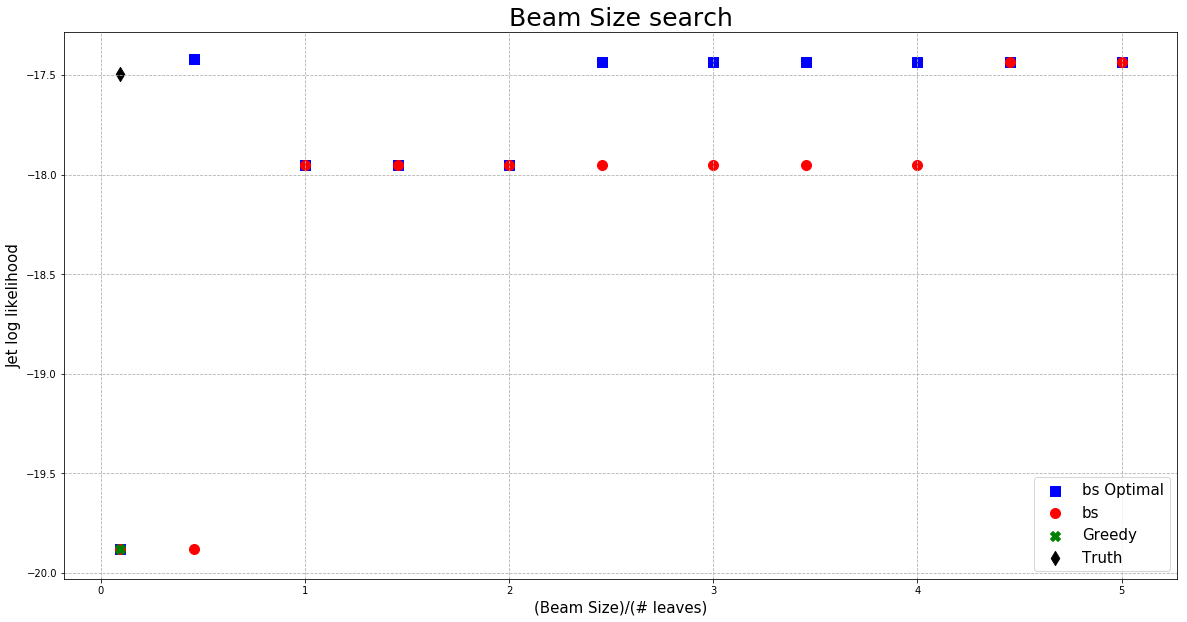

In [214]:
plotBeamSizeLogLH(beamsizeList, filename="100_72")

In [219]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_34",k=34)
print("Total time = ",time.time() - startTime)

Total time =  33.39060592651367


Number of leaves =  22


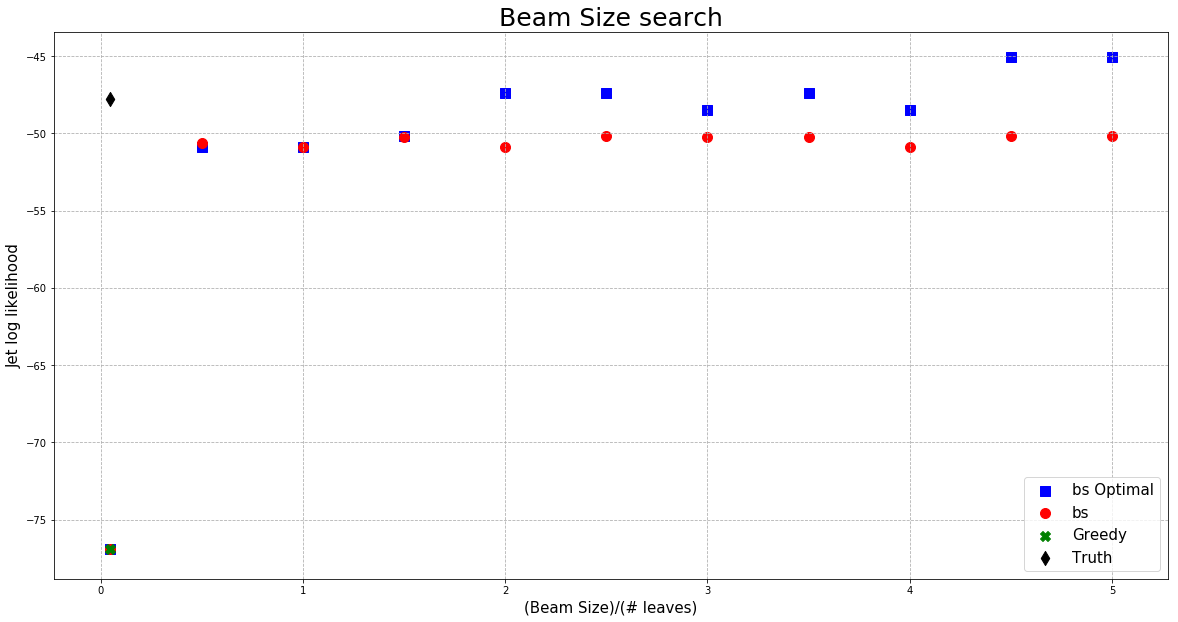

In [220]:
plotBeamSizeLogLH(beamsizeList, filename="100_34")

In [209]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_70",k=70)
print("Total time = ",time.time() - startTime)

Total time =  579.6324317455292


Number of leaves =  50


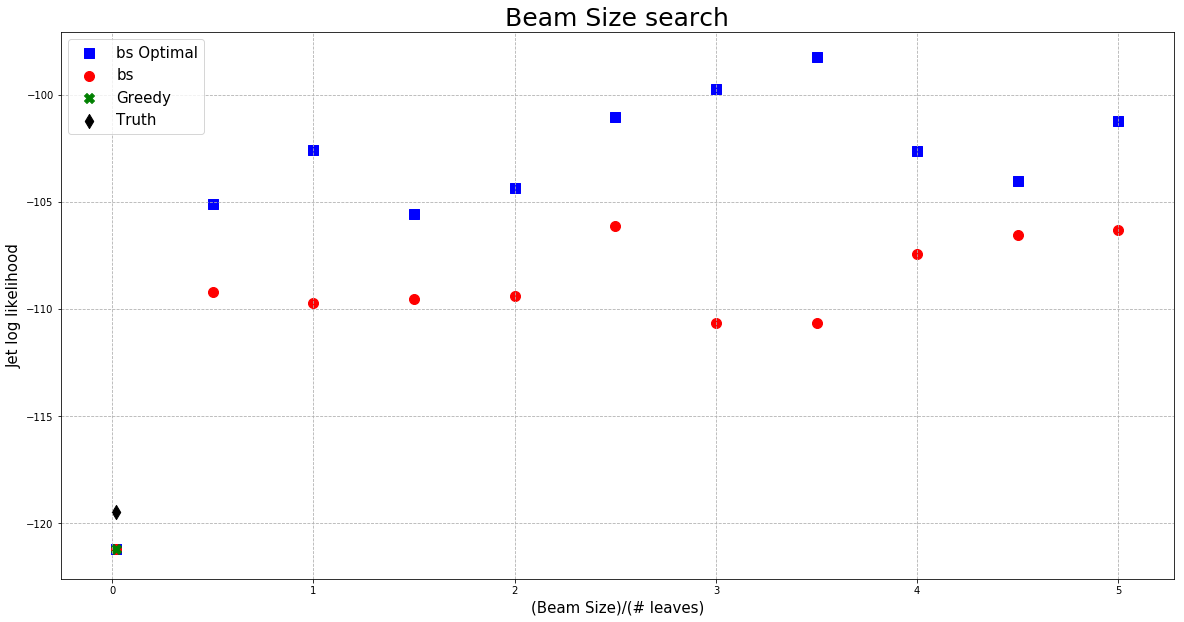

In [210]:
plotBeamSizeLogLH(beamsizeList, filename="100_70")

In [202]:
startTime = time.time()
beamsizeList = BeamSizeLogLH("tree_100_truth", filename="100_62",k=62)
print("Total time = ",time.time() - startTime)

Total time =  6498.875262022018


Number of leaves =  98


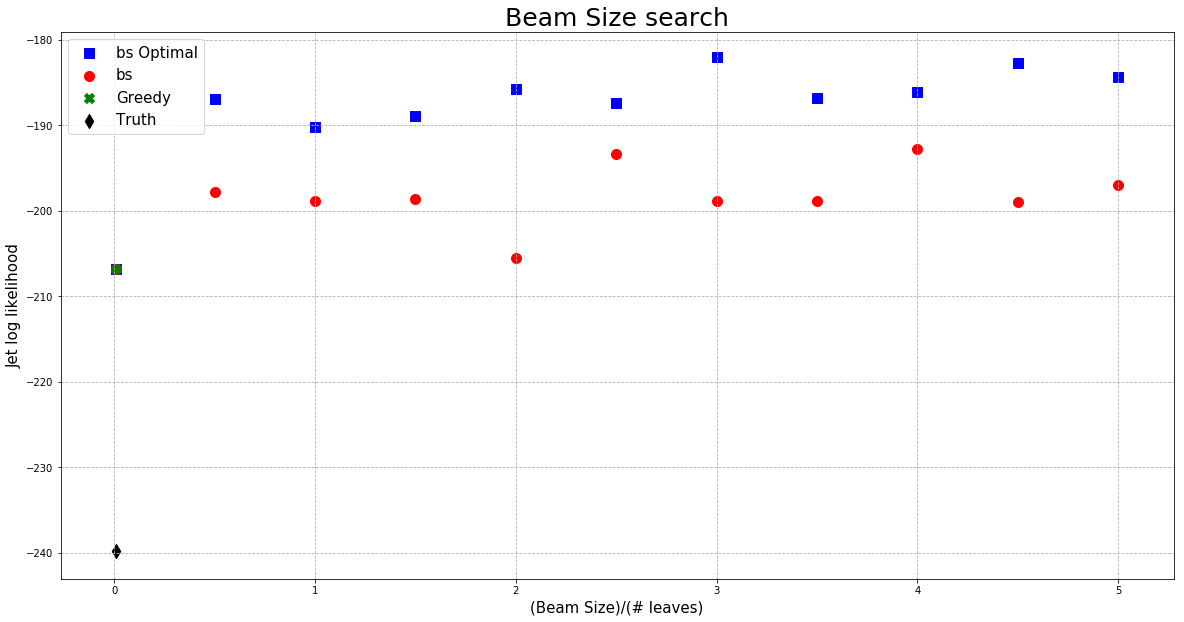

In [203]:
plotBeamSizeLogLH(beamsizeList, filename="100_62")

## TESTS AND CODE COMPARISONS

In [243]:
test =  bs.recluster( 
            truth_jet, 
            beamSize = 10,
            delta_min =  truth_jet["pt_cut"],
            lam = float(truth_jet["Lambda"]),
            N_best = 1,
        )[-1]  

In [244]:
test =  BSO.recluster( 
            truth_jet, 
            beamSize = 10,
            delta_min =  truth_jet["pt_cut"],
            lam = float(truth_jet["Lambda"]),
            N_best = 1,
        )[-1]  

## Duccio's beam search

In [116]:
importlib.reload(beamsearchTJS)

<module 'scripts.beamsearchTJS' from '/Users/sebastian/Dropbox/Documents/Physics_projects/simulator/TreeAlgorithms/scripts/beamsearchTJS.py'>

In [93]:
len(truthConst)

30

In [97]:
truthConst = N2Greedy.getConstituents(
    truth_jet,	
	truth_jet["root_id"],
	[],
)

In [98]:
truthConstTriple = np.concatenate((truthConst,np.array([[0.]]*len(truthConst))),axis=1)

In [127]:
beam_Size = 20

In [128]:
a = time.time()
djet_bs_beam1 = beamsearchTJS.build_beamsearch_tree_TJS(truthConstTriple, 1, truth_jet["pt_cut"], float(truth_jet["Lambda"]))
b = time.time()
display(b-a)

0.1830611228942871

In [129]:
a = time.time()
djet_bs = beamsearchTJS.build_beamsearch_tree_TJS(truthConstTriple, beam_Size, truth_jet["pt_cut"], float(truth_jet["Lambda"]))
b = time.time()
display(b-a)

34.568865060806274

In [130]:
a = time.time()
beamSearch_jets = bs.recluster( 
    truth_jet, 
    beamSize = beam_Size,
    delta_min =  truth_jet["pt_cut"],
    lam = float(truth_jet["Lambda"]),
    N_best = 1,
)
b = time.time()
display(b-a)

10.727005958557129

In [131]:
np.sum(djet_bs["logLH"])

-74.47946266489937

In [132]:
np.sum(beamSearch_jets[-1]["logLH"])

-74.47946197240074

In [133]:
34.57/10.72

3.2248134328358207

In [126]:
8.48/2.48

3.4193548387096775